<center> <img alt=\"DAGsHub\" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png> </center>

# SavtaDepth Sanity Check

### ***This notebook is meant to be run on Google Colab*** - [link to a live version](https://colab.research.google.com/drive/1sARthauqgHfKnsQauKU_kr-954XXBN1p)

#### This notebook is intended as a sanity check and initial end-2-end pipeline for the [SavtaDepth](https://dagshub.com/OperationSavta/SavtaDepth) project which is an Open Source Data Science project. 
#### We'd love to get help from the community, so if you'd like to contribute head over to the [project page](https://dagshub.com/OperationSavta/SavtaDepth) to get started.



In [ ]:
from __future__ import print_function

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

import scipy.io
import cv2
from PIL import Image as PILImage
from google.colab import files
from io import BytesIO
from fastai.vision import open_image
import gc

from fastai.vision import \
  unet_learner, \
  ImageDataBunch, \
  ImageImageList, \
  models, \
  lr_find, \
  ImageList, \
  Path, \
  Image, \
  root_mean_squared_error, \
  get_transforms

import torch

In [ ]:
%reload_ext autoreload
%autoreload 2

# Dataset Creation

The labeled dataset is approximately ***2.8GB***

In [ ]:
# Project Structure
!mkdir workspace
%cd workspace/
!mkdir dataset
# Should use DVC add
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
!wget http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat

/content/workspace/workspace
--2020-10-20 09:17:43--  http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2972037809 (2.8G)
Saving to: ‘nyu_depth_v2_labeled.mat’

nyu_depth_v2_labele 100%[===================>]   2.77G  25.6MB/s    in 79s     

2020-10-20 09:19:02 (36.1 MB/s) - ‘nyu_depth_v2_labeled.mat’ saved [2972037809/2972037809]

--2020-10-20 09:19:02--  http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2626 (2.6K)
Saving to: ‘splits.mat’

splits.mat          100%[===================>]   2.56K  --.-KB/s    in 0s      

2020-10-20 09

### Useful Functions
#### Normalize image to monocular image
#### Associate dataset with labels


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#######################################################################################
# The MIT License

# Copyright (c) 2014       Hannes Schulz, University of Bonn  <schulz@ais.uni-bonn.de>
# Copyright (c) 2013       Benedikt Waldvogel, University of Bonn <mail@bwaldvogel.de>
# Copyright (c) 2008-2009  Sebastian Nowozin                       <nowozin@gmail.com>

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#######################################################################################
#
# Helper script to convert the NYU Depth v2 dataset Matlab file into a set of
# PNG and JPEG images.
#
# See https://github.com/deeplearningais/curfil/wiki/Training-and-Prediction-with-the-NYU-Depth-v2-Dataset

# Normalize image to monocular
def convert_image(i, scene, depth, image, folder):
    img_depth = depth * 1000.0
    img_depth_uint16 = img_depth.astype(np.uint16)
    cv2.imwrite("%s/%05d_depth.png" % (folder, i), img_depth_uint16)

    normalized_depth = np.zeros(img_depth_uint16.shape)
    normalized_depth = cv2.normalize(img_depth_uint16, normalized_depth, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("%s/%05d_depth_norm.png" % (folder, i), normalized_depth)

    image = image[:, :, ::-1]
    image_black_boundary = np.zeros((480, 640, 3), dtype=np.uint8)
    image_black_boundary[7:474, 7:632, :] = image[7:474, 7:632, :]
    cv2.imwrite("%s/%05d.jpg" % (folder, i), image_black_boundary)

# Associate dataset with labels
def extract_official_train_test_set(original_mat, splits_mat, data_folder_path):
    h5_file = h5py.File(original_mat, "r")
    # h5py is not able to open that file. but scipy is
    train_test = scipy.io.loadmat(splits_mat)
    out_folder = data_folder_path

    test_images = set([int(x) for x in train_test["testNdxs"]])
    train_images = set([int(x) for x in train_test["trainNdxs"]])
    print("%d training images" % len(train_images))
    print("%d test images" % len(test_images))
    #print("===========")
    depth = h5_file['depths']

    print("reading", original_mat)

    images = h5_file['images']
    print(u''.join(chr(c) for c in h5_file[obj_ref]) for obj_ref in h5_file['sceneTypes'][0])
    scenes = [u''.join(chr(c) for c in h5_file[obj_ref]) for obj_ref in h5_file['sceneTypes'][0]]

    print("processing images")
    for i, image in enumerate(images):
        print("image", i + 1, "/", len(images))

        idx = int(i) + 1
        if idx in train_images:
            train_test = "train"
        else:
            assert idx in test_images, "index %d neither found in training set nor in test set" % idx
            train_test = "test"

        folder = "%s/%s/%s" % (out_folder, train_test, scenes[i])
        if not os.path.exists(folder):
            os.makedirs(folder)
        convert_image(i, scenes[i], depth[i, :, :].T, image.T, folder)
    #print("===========")
    print("Finished")

## Convert Mat to Proper image dataset

In [ ]:
data_path = './dataset/nyu_depth_v2/official_splits'

In [ ]:
extract_official_train_test_set("nyu_depth_v2_labeled.mat", "splits.mat", data_path)

795 training images
654 test images
reading nyu_depth_v2_labeled.mat
<generator object extract_official_train_test_set.<locals>.<genexpr> at 0x7fe782c2ea98>
processing images
image 1 / 1449
image 2 / 1449
image 3 / 1449
image 4 / 1449
image 5 / 1449
image 6 / 1449
image 7 / 1449
image 8 / 1449
image 9 / 1449
image 10 / 1449
image 11 / 1449
image 12 / 1449
image 13 / 1449
image 14 / 1449
image 15 / 1449
image 16 / 1449
image 17 / 1449
image 18 / 1449
image 19 / 1449
image 20 / 1449
image 21 / 1449
image 22 / 1449
image 23 / 1449
image 24 / 1449
image 25 / 1449
image 26 / 1449
image 27 / 1449
image 28 / 1449
image 29 / 1449
image 30 / 1449
image 31 / 1449
image 32 / 1449
image 33 / 1449
image 34 / 1449
image 35 / 1449
image 36 / 1449
image 37 / 1449
image 38 / 1449
image 39 / 1449
image 40 / 1449
image 41 / 1449
image 42 / 1449
image 43 / 1449
image 44 / 1449
image 45 / 1449
image 46 / 1449
image 47 / 1449
image 48 / 1449
image 49 / 1449
image 50 / 1449
image 51 / 1449
image 52 / 1449
im

## Prepare Dataset

In [ ]:
def get_y_fn(x):
    y = str(x.absolute()).replace('.jpg','_depth_norm.png')
    y = Path(y)

    return y

In [ ]:
data_path = Path('/content/workspace/workspace/dataset/nyu_depth_v2/official_splits')
data = (ImageImageList.from_folder(data_path)
  .filter_by_func(lambda fname: fname.suffix == '.jpg')
  .split_by_folder(train='train', valid='test')
  .label_from_func(get_y_fn).databunch()).normalize()

### Visualize dataset examples 

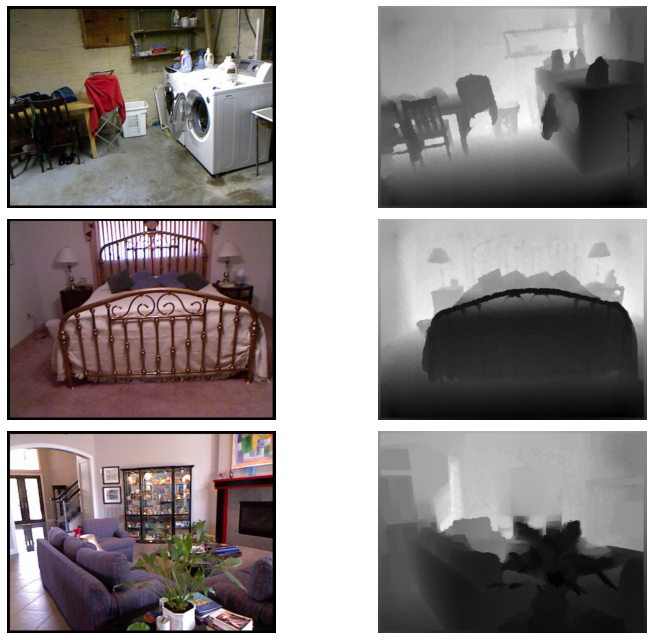

In [ ]:
data.show_batch(rows=3, figsize=(12, 9))

## Train U_Net Model

In [ ]:
# Check what GPU we have
!nvidia-smi

Tue Oct 20 10:46:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |   1697MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(torch.cuda.memory_reserved() - torch.cuda.memory_allocated())/1e6

950.009856

In [ ]:
# Initial values batch_size = 64, num_workers = 2
data.batch_size = 2
data.num_workers = 0

In [ ]:
learner = unet_learner(data, models.resnet50, metrics=root_mean_squared_error, wd=1e-2, loss_func=torch.nn.SmoothL1Loss())
lr_find(learner)

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
(torch.cuda.memory_reserved() - torch.cuda.memory_allocated())/1e6

11538.387968

## Learning Rate Examination
#### Low loss for around LR=1e-03

<Figure size 1440x864 with 0 Axes>

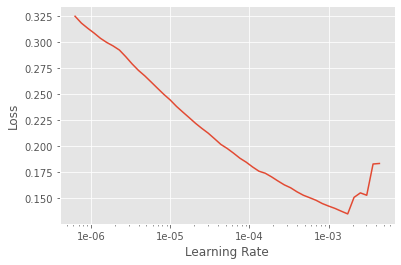

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(20,12))

learner.recorder.plot()

# Train Model

In [ ]:
learner.fit_one_cycle(1,1e-3)
learner.save('baseline_resnet50')

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.033449,0.031545,0.249239,14:49


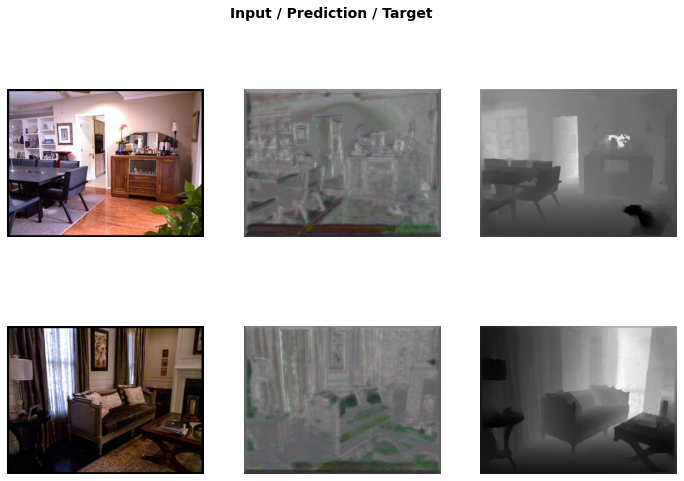

In [ ]:
learner.show_results()

# Fine Tuning

In [ ]:
# finetune
learner.unfreeze
learner.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.031688,0.027327,0.230977,14:48


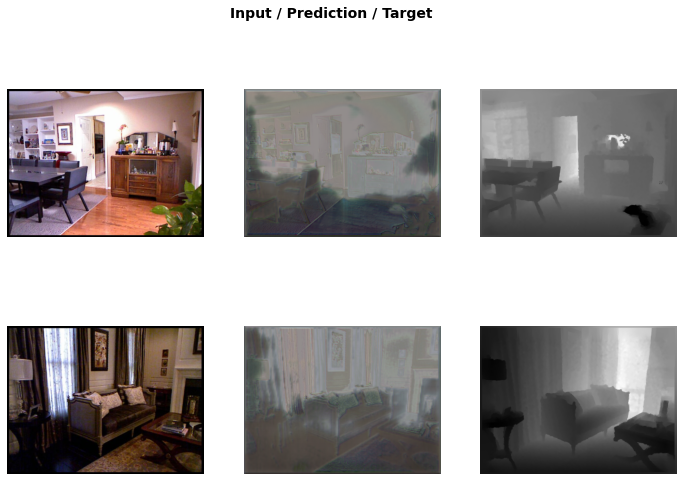

In [ ]:
learner.save('resnet50_fine_tuned')

learner.show_results()

## Predict on Image - not finetuned

In [ ]:
learner = learner.load("/content/workspace/workspace/dataset/nyu_depth_v2/official_splits/models/baseline_resnet50")

/content/images/images


Saving inner3.jpg to inner3.jpg
/content/images


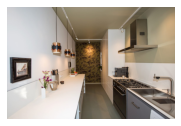

In [ ]:
!mkdir images
%cd images

# Upload Image
uploaded = files.upload()
original = open_image(BytesIO(uploaded[list(uploaded.keys())[0]]))

# Preview original image
original.show()

%cd ../

# https://www.bestinteriordesigners.eu/wp-content/uploads/2019/10/inner3.jpg

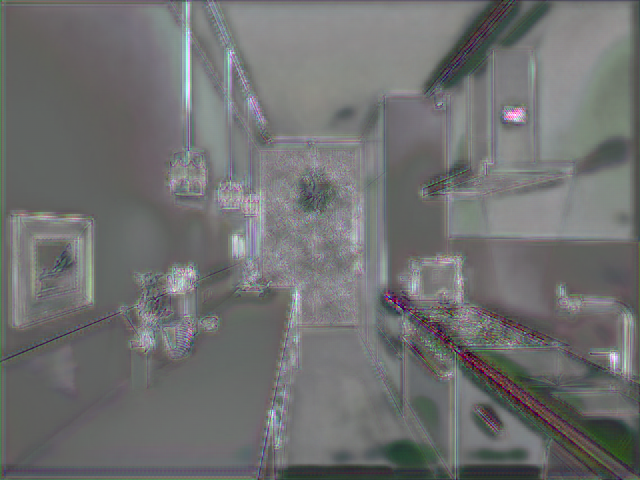

In [ ]:
original_shape = (original.shape[1],original.shape[2])

minified = original.resize((3,480,640))
predicted_depth_map = learner.predict(minified)
predicted_depth_map[0].save('images/test.jpg')
predicted_depth_map[0]

In [ ]:
output = PILImage.open('images/test.jpg')
output = output.resize(original_shape)
output.save('images/test.jpg')

# Predicted on Image - finetuned

In [ ]:
learner = learner.load("/content/workspace/workspace/dataset/nyu_depth_v2/official_splits/models/resnet50_fine_tuned")

mkdir: cannot create directory ‘images’: File exists
/content/images/images


Saving inner3.jpg to inner3 (1).jpg
/content/images


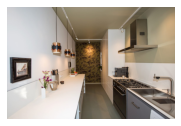

In [ ]:
!mkdir images
%cd images

# Upload Image
uploaded = files.upload()
original = open_image(BytesIO(uploaded[list(uploaded.keys())[0]]))

# Preview original image
original.show()

%cd ../

# https://www.bestinteriordesigners.eu/wp-content/uploads/2019/10/inner3.jpg

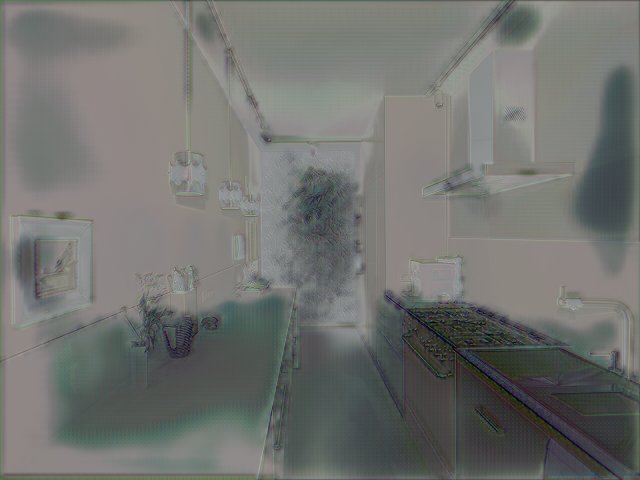

In [ ]:
original_shape = (original.shape[1],original.shape[2])
minified = original.resize((3,480,640))
predicted_depth_map = learner.predict(minified)
predicted_depth_map[0].save('images/test_finetuned.jpg')
predicted_depth_map[0]

In [ ]:
output = PILImage.open('images/test_finetuned.jpg')
output = output.resize(original_shape)
output.save('images/test_finetuned.jpg')

# Cleanup code

In [ ]:
del learner
del data
torch.cuda.empty_cache()
gc.collect()

2171